<a href="https://colab.research.google.com/github/hyunjaec/MScA_Machine_Learning_Project/blob/main/medical_deepfakes_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import pydicom
import scipy.ndimage

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [4]:
#! ls 'drive/My Drive/data_ml'
path = '/Users/milantoolsidas/Documents/UChicago/Spring_2022/MScA_31009_Machine_Learning/Project/'

In [5]:
len(os.listdir(path + 'data/Tampered Scans/Experiment 1 - Blind'))

80

In [6]:
from tqdm import tqdm 

scan_uuids = os.listdir(path + 'data/Tampered Scans/Experiment 1 - Blind')

scan = []
spacing = []
orientation = []
origin = []
raw_slices = []
for id in tqdm(scan_uuids):
  sc, sp, ori, org, rs = load_dicom(path + '/data/Tampered Scans/Experiment 1 - Blind/'+id)
  scan.append(sc)
  spacing.append(sp)
  orientation.append(ori)
  origin.append(org)
  raw_slices += rs

print('The CT scan has the dimensions of',scan[0].shape,'  (z,y,x)')

  0%|          | 0/80 [00:00<?, ?it/s]<ipython-input-3-6217c5542aed>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spacing_z = np.float(first_slice_data.SliceThickness)
100%|██████████| 80/80 [03:35<00:00,  2.69s/it]

The CT scan has the dimensions of (286, 512, 512)   (z,y,x)


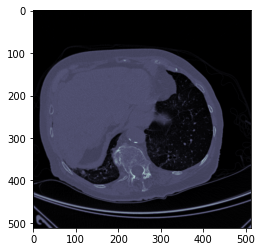

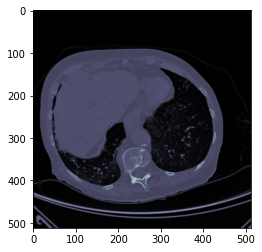

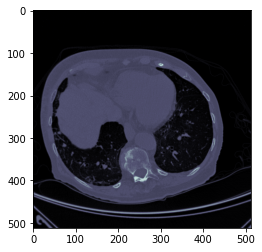

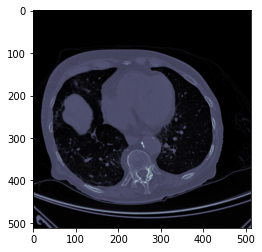

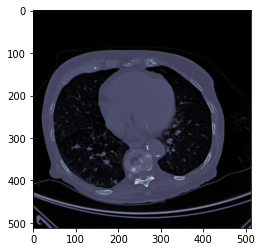

In [7]:
from matplotlib import pyplot as plt

for slice_indx in range(50,100,10):
    plt.imshow(scan[0][slice_indx,:,:],cmap='bone',vmin=-1000,vmax=2000)
    plt.show()

In [8]:
df = pd.read_csv(path + 'data/Tampered Scans/labels_exp1.csv')
locations = df.loc[df['uuid'].isin([int(i) for i in scan_uuids])]
locations

,type,uuid,slice,x,y
0,FB,1280,100,323,381
1,FB,1009,76,354,288
2,FB,7794,79,163,191
3,FB,7794,94,338,243
4,FB,2997,45,156,135
...,...,...,...,...,...
128,TM,7507,201,316,362
129,TM,7507,319,125,323
130,TM,2190,48,147,379
131,TM,2190,213,141,336


In [9]:
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        try:
          np.ones(np.array(X.shape) + shape * 2)
        except:
          return "No"
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)


In [10]:
cut_cubes = []
for i in tqdm(range(len(locations))):
    location = locations.iloc[i]
    for s in scan:
        coord = np.array([location['slice'],location['y'],location['x']])
        cut_cubes.append(cutCube(s,coord,(64,64,64)))

#disply the slices of each cut cube:
# for cube in cut_cubes:
#     plt.figure(num=None, figsize=(10, 10), dpi=200)
#     for i in range(64):
#         plt.subplot(8,8,i+1)
#         plt.axis('off')
#         plt.tight_layout()
#         try:
#           plt.imshow(cube[i,:,:],cmap='bone')
#         except:
#           print(i)
#     plt.show()

100%|██████████| 133/133 [11:34<00:00,  5.22s/it]


In [11]:
import os
dir = path + 'data/Tampered Scans/Experiment 1 - Blind/'
r=[]
for root, dirs, files in os.walk(dir):
  r.append(root)

In [12]:
len(r)

81

In [13]:
from collections import Counter

label_df1 = pd.read_csv(path + 'data/Results/Response EXP1 - Reviewer 1_instances.csv')
label_df2 = pd.read_csv(path + 'data/Results/Response EXP1 - Reviewer 2_instances.csv')
label_df3 = pd.read_csv(path + 'data/Results/Response EXP1 - Reviewer 3_instances.csv')

preds = pd.concat([label_df1[['uuid','label']], label_df2[['label']], label_df3[['label']]], axis = 1)
preds.columns = ['uuid','label1','label2','label3']

def final_label(row):
    if row.label1 == row.label2 == row.label3:
        return row.label1
    else:
        cnts = Counter([row.label1, row.label2, row.label3])
        return cnts.most_common(1)[0]

# preds = pd.concat([label_df1[['label','prediction','confidence']], label_df2[['label','prediction','confidence']], label_df3[['label','prediction','confidence']]], axis = 1)
# preds.columns = ['label1','prediction1','confidence1','label2','prediction2','confidence2','label3','prediction3','confidence3']

# def final_label(row):
#   row.label1 = int(row.label1)
#   row.label2 = int(row.label2)
#   row.label3 = int(row.label3)
#   if row.label1 == 0:
#         row.label1 == -1
#   if row.label2 == 0:
#         row.label2 == -1
#   if row.label3 == 0:
#         row.label3 == -1
#   if row.label1 == row.label2 == row.label3:
#     return bool(row.label1)
#   else:
#     return bool(np.sign((row.label1*row.confidence1 + row.label1*row.confidence2 + row.label1*row.confidence3) / 3))

preds['label'] = preds.apply(lambda row: final_label(row), axis = 1)
label_df = pd.concat([label_df1.drop('label', axis = 1), preds['label']], axis = 1)
label_df.head()

,type,uuid,slice,x,y,detected,detected_diam,label
0,FB,1280,100,323,381,False,0.0,True
1,FB,1009,76,354,288,False,0.0,True
2,FB,7794,79,163,191,False,0.0,True
3,FB,7794,94,338,243,False,0.0,True
4,FB,2997,45,156,135,False,0.0,True


In [14]:
len(label_df)

133

In [15]:
df_true = label_df.loc[label_df['label']==True]
df_false = label_df.loc[label_df['label']==False]

In [16]:
df_true.uuid[0]

1280

In [17]:
len(df_true.uuid.unique()), len(df_false.uuid.unique())

(40, 40)

In [18]:
df_true = df_true.reset_index()
df_false = df_false.reset_index()

In [19]:
from tqdm import tqdm

def image_cut_processing(df):
  cut_cubes = []
  for i in tqdm(range(0,len(df))):
    scan, spacing, orientation, origin, raw_slices = load_dicom(path + 'data/Tampered Scans/Experiment 1 - Blind/'+str(df.uuid[i]))
    uuid_row = df.loc[df['uuid'] == df.uuid[i]]
    for j in range(len(uuid_row)):
      location = uuid_row.iloc[j]
      coord = np.array([location['slice'],location['y'],location['x']])
      if (cutCube(scan,coord,(64,64,64))) != "No":
        cut_cubes.append(cutCube(scan,coord,(64,64,64)))
  return cut_cubes
  

In [20]:
true_cut_images = image_cut_processing(df_true)

  0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-3-6217c5542aed>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spacing_z = np.float(first_slice_data.SliceThickness)
<ipython-input-19-f9bcb5bb22aa>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (cutCube(scan,coord,(64,64,64))) != "No":
100%|██████████| 84/84 [03:21<00:00,  2.40s/it]


In [21]:
false_cut_images = image_cut_processing(df_false)

  0%|          | 0/49 [00:00<?, ?it/s]<ipython-input-3-6217c5542aed>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spacing_z = np.float(first_slice_data.SliceThickness)
<ipython-input-19-f9bcb5bb22aa>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (cutCube(scan,coord,(64,64,64))) != "No":
100%|██████████| 49/49 [01:10<00:00,  1.43s/it]


In [22]:
list_true = [True for i in range(len(true_cut_images))]
list_false = [False for i in range(len(false_cut_images))]
y = list_true + list_false
y = np.array(y)
len(y)

260

In [23]:
#y = pd.get_dummies(y)
y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
X = true_cut_images + false_cut_images
len(X)

260

In [25]:
len(X), len(y)

(260, 260)

In [26]:
# y['label'] = (y[True] == 1).astype(int)

In [27]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y['label'], test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [28]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [29]:
len(y_train), len(y_test)

(208, 52)

In [30]:
X_test[8].shape, y_train[8].shape

((64, 64, 64), ())

In [31]:
X_train.shape

(208, 64, 64, 64)

In [32]:
nsamples, nx, ny, nz = X_train.shape
X_train_flattened = X_train.reshape((nsamples,nx*ny*nz))
X_test_flattened = X_test.reshape((X_test.shape[0],nx*ny*nz))

In [33]:
X_train_flattened.shape

(208, 262144)

In [34]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_flattened)
X_test_scaled = ss.fit_transform(X_test_flattened)

In [35]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_scaled, y_train)

SVC()

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

preds = svc.predict(X_test_scaled)

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 4  4]
 [ 0 44]]


              precision    recall  f1-score   support

       False       1.00      0.50      0.67         8
        True       0.92      1.00      0.96        44

    accuracy                           0.92        52
   macro avg       0.96      0.75      0.81        52
weighted avg       0.93      0.92      0.91        52



In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestClassifier


parameters = {'C':np.arange(0.01,2.01,0.2), 'kernel':('linear', 'poly', 'rbf', 'sigmoid')}
svc = SVC(kernel = 'linear')
svc_grid = GridSearchCV(svc, parameters, cv = KFold(n_splits = 5), verbose = 10)
svc_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START C=0.01, kernel=linear......................................
[CV 1/5; 1/40] END .......C=0.01, kernel=linear;, score=0.952 total time=   4.7s
[CV 2/5; 1/40] START C=0.01, kernel=linear......................................
[CV 2/5; 1/40] END .......C=0.01, kernel=linear;, score=0.881 total time=   4.7s
[CV 3/5; 1/40] START C=0.01, kernel=linear......................................
[CV 3/5; 1/40] END .......C=0.01, kernel=linear;, score=0.952 total time=   4.8s
[CV 4/5; 1/40] START C=0.01, kernel=linear......................................
[CV 4/5; 1/40] END .......C=0.01, kernel=linear;, score=0.951 total time=   6.4s
[CV 5/5; 1/40] START C=0.01, kernel=linear......................................
[CV 5/5; 1/40] END .......C=0.01, kernel=linear;, score=0.951 total time=   5.1s
[CV 1/5; 2/40] START C=0.01, kernel=poly........................................
[CV 1/5; 2/40] END .........C=0.01, kernel=poly

[CV 5/5; 10/40] END C=0.41000000000000003, kernel=poly;, score=0.854 total time=   6.4s
[CV 1/5; 11/40] START C=0.41000000000000003, kernel=rbf.........................
[CV 1/5; 11/40] END C=0.41000000000000003, kernel=rbf;, score=0.810 total time=   8.0s
[CV 2/5; 11/40] START C=0.41000000000000003, kernel=rbf.........................
[CV 2/5; 11/40] END C=0.41000000000000003, kernel=rbf;, score=0.786 total time=   7.9s
[CV 3/5; 11/40] START C=0.41000000000000003, kernel=rbf.........................
[CV 3/5; 11/40] END C=0.41000000000000003, kernel=rbf;, score=0.833 total time=   8.1s
[CV 4/5; 11/40] START C=0.41000000000000003, kernel=rbf.........................
[CV 4/5; 11/40] END C=0.41000000000000003, kernel=rbf;, score=0.927 total time=   7.9s
[CV 5/5; 11/40] START C=0.41000000000000003, kernel=rbf.........................
[CV 5/5; 11/40] END C=0.41000000000000003, kernel=rbf;, score=0.854 total time=   6.9s
[CV 1/5; 12/40] START C=0.41000000000000003, kernel=sigmoid.............

[CV 5/5; 20/40] END .....C=0.81, kernel=sigmoid;, score=0.854 total time=   4.6s
[CV 1/5; 21/40] START C=1.01, kernel=linear.....................................
[CV 1/5; 21/40] END ......C=1.01, kernel=linear;, score=0.952 total time=   4.8s
[CV 2/5; 21/40] START C=1.01, kernel=linear.....................................
[CV 2/5; 21/40] END ......C=1.01, kernel=linear;, score=0.881 total time=   4.4s
[CV 3/5; 21/40] START C=1.01, kernel=linear.....................................
[CV 3/5; 21/40] END ......C=1.01, kernel=linear;, score=0.952 total time=   4.4s
[CV 4/5; 21/40] START C=1.01, kernel=linear.....................................
[CV 4/5; 21/40] END ......C=1.01, kernel=linear;, score=0.951 total time=   5.8s
[CV 5/5; 21/40] START C=1.01, kernel=linear.....................................
[CV 5/5; 21/40] END ......C=1.01, kernel=linear;, score=0.951 total time=   4.3s
[CV 1/5; 22/40] START C=1.01, kernel=poly.......................................
[CV 1/5; 22/40] END ........

[CV 5/5; 30/40] END C=1.4100000000000001, kernel=poly;, score=0.902 total time=  14.8s
[CV 1/5; 31/40] START C=1.4100000000000001, kernel=rbf..........................
[CV 1/5; 31/40] END C=1.4100000000000001, kernel=rbf;, score=0.905 total time=  26.8s
[CV 2/5; 31/40] START C=1.4100000000000001, kernel=rbf..........................
[CV 2/5; 31/40] END C=1.4100000000000001, kernel=rbf;, score=0.786 total time=  38.7s
[CV 3/5; 31/40] START C=1.4100000000000001, kernel=rbf..........................
[CV 3/5; 31/40] END C=1.4100000000000001, kernel=rbf;, score=0.905 total time=  32.5s
[CV 4/5; 31/40] START C=1.4100000000000001, kernel=rbf..........................
[CV 4/5; 31/40] END C=1.4100000000000001, kernel=rbf;, score=0.951 total time=  26.3s
[CV 5/5; 31/40] START C=1.4100000000000001, kernel=rbf..........................
[CV 5/5; 31/40] END C=1.4100000000000001, kernel=rbf;, score=0.927 total time=  14.5s
[CV 1/5; 32/40] START C=1.4100000000000001, kernel=sigmoid....................

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(kernel='linear'),
             param_grid={'C': array([0.01, 0.21, 0.41, 0.61, 0.81, 1.01, 1.21, 1.41, 1.61, 1.81]),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             verbose=10)

In [38]:
svc_grid.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

preds2 = svc_grid.predict(X_test_scaled)

print(confusion_matrix(y_test, preds2))
print('\n')
print(classification_report(y_test, preds2))

[[ 6  2]
 [ 1 43]]


              precision    recall  f1-score   support

       False       0.86      0.75      0.80         8
        True       0.96      0.98      0.97        44

    accuracy                           0.94        52
   macro avg       0.91      0.86      0.88        52
weighted avg       0.94      0.94      0.94        52

